In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
vid_name = "rain_crop.mp4"


#imports to be able to use surgery dataset from action recognition model




%cd /pasteur/u/egoodma/multitaskmodel/MULTITASK_FILES/TSM_FILES/

from dataset import *
from barbar import Bar
import click
from train import get_train_val_data_loaders, run_epoch
from model import get_model_name, save_model, save_results, get_model
import torch.nn as nn
import pandas as pdpas
from torch.utils.data import DataLoader
import cv2
import utils
import os

def get_test_data_loaders(segments_df, batch_size, data_dir='data/', model='BLV', pre_crop_size=256,
                                                                    aug_method='val'):
    df = segments_df.sort_values(by=['video_id', 'start_seconds'])
    test_dataset = SurgeryDataset(df, data_dir=data_dir, mode='test', model=model, balance=False,
                                   pre_crop_size=pre_crop_size, aug_method=aug_method)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=0, pin_memory=False)
    return test_data_loader


def get_video_path(video_id, data_dir='data/'):
    return os.path.join(data_dir + video_id + ".mp4")


def get_video_duration(filename):
    video = cv2.VideoCapture(filename)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)
    return frame_count, fps


def anns_from_video_ids(video_ids, data_dir, offset=0):
    rows = []
    for video_id in video_ids:
        video_path = get_video_path(video_id, data_dir)
        print("Studying video at path", video_path)
        if not os.path.exists(video_path):
            print("Video not downloaded: %s" % video_id)
            continue
        frame_count, fps = get_video_duration(video_path)
        if frame_count == 0:
            print("WARNING: duration for %s is zero" % video_id)
        num_anns = int(frame_count / 16)
        segment_length = 16 / fps
        for i in range(num_anns):
            start_seconds = offset + i * segment_length
            label = 'background'
            row = {'start_seconds': start_seconds,
                   'video_id': video_id,
                   'end_seconds': start_seconds + segment_length,
                   'duration': segment_length,
                   'label': label,
                   'category': label}
            rows.append(row)
    anns_df = pd.DataFrame(rows)
    return anns_df

directory = "/pasteur/u/egoodma/projects/videos/"
video = [vid_name[:-4]]

num_categories = 4
SurgeryDataset.categories = DEFAULT_CATEGORIES[0:num_categories]
segments_df = anns_from_video_ids(video, directory)
test_data_loader = get_test_data_loaders(segments_df, batch_size=1, data_dir = directory)
print('The length of the dataloader is', len(test_data_loader))

/pasteur/u/egoodma/multitaskmodel/MULTITASK_FILES/TSM_FILES
IMPORTING ACTIONS DATASET
Studying video at path /pasteur/u/egoodma/projects/videos/rain_crop.mp4
The length of the dataloader is 328


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime

import csv
import os
import shutil
import json
import time
import cv2
import numpy as np

import sys
sys.path.append('/pasteur/u/egoodma/surgery-hand-detection/deep-high-resolution-net.pytorch/lib')
sys.path.append("/pasteur/u/egoodma/multitaskmodel/MULTITASK_FILES/RETINANET_FILES/src/pytorch-retinanet")

from PIL import Image

from pycocotools.coco import COCO

import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision

from retinanet.dataloader import CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer, InferenceDataset
from retinanet import csv_eval, model

from config import cfg
from config import update_config
from torch.utils.data import Dataset, DataLoader #added for tools

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

print("All packages imported!")
label_dict = {0:"background", 1:"cutting", 2:"suturing", 3:"tying"}

def inference(cur_video, data_loader):

    print("STARTING INFERENCE ON VIDEO {}".format(cur_video))

    #tool_model = "/pasteur/u/egoodma/multitaskmodel/logs/12.6_multitaskmodel_2/12.6_multitaskmodel_2_final.pt"
    tool_model = "/pasteur/u/egoodma/projects/logs/12.13_rain_model_90pc_aug/best_model.pt"

    #load tool model
    device = torch.device("cuda")
    print("Building retinanet!")
    retinanet = model.resnet18(num_classes=4)
    print("Retinanet built!")
    retinanet = torch.load(tool_model) 

    retinanet.to(device)
    
    tool_model = retinanet
    if torch.cuda.is_available():
        tool_model = tool_model.cuda()
        tool_model = torch.nn.DataParallel(tool_model).cuda()
        tool_model.eval()

    #########NOW#THAT#MODELS#ARE#SETUP#########
    video = "/pasteur/u/egoodma/projects/videos/rain_crop.mp4"

    video = cv2.VideoCapture(video)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print("HEIGHT", height, width)
    fps = video.get(cv2.CAP_PROP_FPS)
    video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    total_tool_boxes = []
    actions = []

    for index, (scale, data, record_ids, labels) in enumerate(test_data_loader):

        print("Scale is", scale)
            
        print("\nStudying batch", index, data.squeeze().shape)

        print(data.squeeze().cuda().float().shape, "SHAPE")
        
        batch_nms_scores, batch_nms_class, batch_transformed_anchors, action_logits = tool_model(data.squeeze().cuda().float())

        print(index*16, label_dict[int(torch.argmax(action_logits))])
        
        #print(batch_nms_scores[0].shape, batch_nms_class[0].shape, batch_transformed_anchors[0].shape)
        #print(batch_nms_scores[0])
        
        for i in range(len(batch_nms_scores)):
            nms_scores = batch_nms_scores[i]
            #print(nms_scores)
            transformed_anchors = batch_transformed_anchors[i]
            nms_class = batch_nms_class[i]
            idxs = np.where(nms_scores.cpu() >= .25)
            #print(action_logits)#, nms_scores, transformed_anchors)
            counter = 0
            tool_coords_and_label = [] #number of tools and hands per frame
            if len(idxs[0]) > 0:
                for idx in idxs[0]:
                    scale = float(scale)
                    a = float(transformed_anchors[idx].detach()[0]/scale)
                    b = float(transformed_anchors[idx].detach()[1]/scale)
                    c = float(transformed_anchors[idx].detach()[2]/scale)
                    d = float(transformed_anchors[idx].detach()[3]/scale)
                    e = float(nms_scores[idx].detach()) #this last coordinate is the ID
                    #counter += 1; print("FOUND", e)
                    #print(a, b, c, d, e)
                    tool_coords_and_label.append([a, b, c, d, e])
            if len(tool_coords_and_label) > 0:
                total_tool_boxes.append(tool_coords_and_label)

            else:
                total_tool_boxes.append([])    
                
        actions += [label_dict[int(torch.argmax(action_logits))] for _ in range(16)]
        #print(actions)

    print('\n ...inference complete!')

    return total_tool_boxes, actions


def output_video_and_json(new_total_tool_boxes, actions):

    #http://www.fifi.org/doc/wwwcount/Count2.5/rgb.txt.html
    #except flip right and left because BGR instead of RGB
    colors = [(255, 191, 0), (50, 205, 50), (255, 102, 244), (18, 185, 255)]
    #tools[bovie, forceps, needledriver, hand]
    #colors = [DeepSkyBlue1, limegreen, MediumOrchid1, DarkGoldenrod1]

    
    #input movie to overlay predictions on
    argsvideo = "/pasteur/u/egoodma/projects/videos/rain_crop.mp4"
    video = cv2.VideoCapture(argsvideo)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = video.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc('F', 'M', 'P', '4')
    out_video = "/pasteur/u/egoodma/projects/out_finally_new.mp4"
    video_tracked = cv2.VideoWriter(out_video, fourcc, fps, (int(width), int(height)))

    json_data = {}

    frame_num = 0
    
    while video.isOpened() and frame_num < len(new_total_tool_boxes):
        
        tool_boxes = new_total_tool_boxes[frame_num]

        print("Json'ing Frame Number ", frame_num, end='\r')
        
        _, frame = video.read()
        
        if frame is None or frame.size == 0:
            break

        img = frame
        image_debug = img.copy()
        image_pose = img.copy()

        json_preds = []

        for it, box in enumerate(tool_boxes):
            if len(box) > 0:
                json_preds.append({"drop": [float(box[0]), float(box[1]), float(box[2]), float(box[3]), float(box[4])]})
                cv2.rectangle(image_debug, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 10, 0),
                              thickness=1)
        
        
        
        
        
        
        video_tracked.write(image_debug)


        json_data[frame_num] = json_preds

        frame_num += 1

    json.dump(json_data, open("/pasteur/u/egoodma/projects/out_finally_new.json", "w"))

    video.release()
    video_tracked.release()
    print("RELEASING ", out_video)


def main():
    print("\n\nWe are studying video {} in directory {}:".format(video[0], directory))
    bboxes, actions = inference(directory+video[0], test_data_loader)
    output_video_and_json(bboxes, actions)


if __name__ == '__main__':
    main()


/pasteur/u/egoodma/MINICONDA/envs/actionshandstools/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/pasteur/u/egoodma/MINICONDA/envs/actionshandstools/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


Adding new multi-task model to path!
All packages imported!


We are studying video rain_crop in directory /pasteur/u/egoodma/projects/videos/:
STARTING INFERENCE ON VIDEO /pasteur/u/egoodma/projects/videos/rain_crop
Building retinanet!
Creating classification and regression heads
Creating action model
Retinanet built!
HEIGHT 250.0 250.0
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 0 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
0 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 1 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
16 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 2 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
32 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 3 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
48 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 4 torch.Size([16, 

848 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 54 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
864 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 55 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
880 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 56 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
896 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 57 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
912 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 58 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
928 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 59 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
944 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 60 torch.Size([16, 3, 672, 672])
torch.S

1744 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 110 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
1760 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 111 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
1776 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 112 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
1792 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 113 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
1808 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 114 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
1824 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 115 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
1840 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 116 torch.Size([16, 3, 672,

2624 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 165 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
2640 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 166 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
2656 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 167 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
2672 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 168 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
2688 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 169 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
2704 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 170 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
2720 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 171 torch.Size([16, 3, 672,

3504 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 220 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
3520 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 221 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
3536 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 222 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
3552 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 223 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
3568 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 224 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
3584 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 225 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
3600 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 226 torch.Size([16, 3, 672,

4384 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 275 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
4400 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 276 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
4416 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 277 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
4432 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 278 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
4448 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 279 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
4464 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 280 torch.Size([16, 3, 672, 672])
torch.Size([16, 3, 672, 672]) SHAPE
4480 background
Scale is tensor([2.5600], dtype=torch.float64)

Studying batch 281 torch.Size([16, 3, 672,

In [5]:
'''%cd /pasteur/u/egoodma/projects/combined_utils
from process_data import *

%cd /pasteur/u/egoodma/projects

vid_dir = "/pasteur/u/egoodma/projects/"
vid_name = "rain_crop.mp4"
det_name = "out_finally_full_best.json"
smoothed_video = vid_name[:-4] + "_tuned" 

for_counting_frames = cv2.VideoCapture(vid_dir+vid_name)
final_frame = 2500 #int(for_counting_frames.get(cv2.CAP_PROP_FRAME_COUNT))
print("Video has {} frames".format(final_frame))

total_drop_boxes = json_back_to_boxes(vid_dir, det_name)
#print("Lots of boxes", total_drop_boxes[0:100], "\n\n")
#total_drop_boxes = filt(vid_dir+vid_name, total_drop_boxes)
#print("New boxes", total_drop_boxes[0:100], "\n\n")
total_drop_boxes = smooth(vid_dir+vid_name, total_drop_boxes)
print("After smooth", total_drop_boxes[0:100], "\n\n")

fps = annotate_videos(vid_dir+vid_name, vid_dir+smoothed_video+".mp4", total_drop_boxes)'''

'%cd /pasteur/u/egoodma/projects/combined_utils\nfrom process_data import *\n\n%cd /pasteur/u/egoodma/projects\n\nvid_dir = "/pasteur/u/egoodma/projects/"\nvid_name = "rain_crop.mp4"\ndet_name = "out_finally_full_best.json"\nsmoothed_video = vid_name[:-4] + "_tuned" \n\nfor_counting_frames = cv2.VideoCapture(vid_dir+vid_name)\nfinal_frame = 2500 #int(for_counting_frames.get(cv2.CAP_PROP_FRAME_COUNT))\nprint("Video has {} frames".format(final_frame))\n\ntotal_drop_boxes = json_back_to_boxes(vid_dir, det_name)\n#print("Lots of boxes", total_drop_boxes[0:100], "\n\n")\n#total_drop_boxes = filt(vid_dir+vid_name, total_drop_boxes)\n#print("New boxes", total_drop_boxes[0:100], "\n\n")\ntotal_drop_boxes = smooth(vid_dir+vid_name, total_drop_boxes)\nprint("After smooth", total_drop_boxes[0:100], "\n\n")\n\nfps = annotate_videos(vid_dir+vid_name, vid_dir+smoothed_video+".mp4", total_drop_boxes)'

In [11]:
 

#move to directory where demo.py is
%cd /pasteur/u/egoodma/surgery-hand-detection/

#this is the directory where we are analyzing videos
!(python3 /pasteur/u/egoodma/projects/notebooks/tracking_rain.py \
  --seq_path /pasteur/u/egoodma/projects/out_finally_new.json \
  --vid_path /pasteur/u/egoodma/projects/videos/rain_crop.mp4 \
  --out_vid /pasteur/u/egoodma/projects/videos/rain_crop_tracked_1.mp4 \
  --out_json /pasteur/u/egoodma/projects/rain_tracked.json \
  --vis )

            

/pasteur/u/egoodma/surgery-hand-detection
Output directory completed!
Initialized mot_tracker!
OpenCV: FFMPEG: tag 0x34504d46/'FMP4' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
About to open video!
HERE IS RAIN_INIT 63

 {12: 0, 11: 0, 10: 0, 9: 0, 8: 0, 7: 0, 6: 0, 5: 0, 4: 0, 3: 0, 2: 0, 1: 0, 0: 0, 19: 5, 22: 6, 24: 7, 30: 10, 28: 10, 37: 11, 35: 11, 34: 11, 33: 11, 32: 11, 31: 11, 38: 12, 41: 13, 44: 14, 46: 14, 51: 16, 50: 16, 63: 21, 66: 22, 68: 23, 74: 26, 72: 26, 81: 27, 79: 27, 78: 27, 77: 27, 76: 27, 75: 27, 82: 28, 85: 29, 87: 29, 95: 32, 93: 32, 88: 30, 98: 33, 96: 33, 103: 35, 109: 36, 108: 36, 107: 36, 106: 36, 104: 35, 116: 38, 115: 38, 118: 39, 117: 39, 119: 40, 122: 41, 121: 41, 125: 43, 126: 44, 131: 45, 129: 45, 133: 47, 136: 48, 135: 48, 139: 49, 144: 51, 150: 52, 149: 52, 148: 52, 147: 52, 145: 51, 157: 54, 156: 54, 159: 55, 158: 55, 160: 56, 163: 57, 162: 57, 166: 59, 167: 60, 172:

defaultdict(<class 'list'>, {0: [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 19, 22, 24, 30, 28, 37, 35, 34, 33, 32, 31, 38, 41, 44, 46, 51, 50, 63, 66, 68, 74, 72, 81, 79, 78, 77, 76, 75, 82, 85, 87], 1: [95, 93, 88, 98, 96, 103, 109, 108, 107, 106, 104, 116, 115, 118, 117, 119, 122, 121, 125, 126, 131, 129, 133, 136, 135, 139, 144, 150, 149, 148, 147, 145, 157, 156, 159, 158, 160, 163, 162, 166], 2: [167, 172, 170, 177, 176, 182, 184, 183, 188, 185, 191, 196, 195, 201, 203, 202, 204, 207, 212, 217, 221, 224, 226, 225, 230, 227, 234, 239, 238, 244, 246, 245], 3: [247, 250, 255, 253, 261, 252, 263, 269, 268, 267, 265, 274, 273, 271, 275, 281, 285, 279, 286, 280, 289, 288, 293, 298, 297, 302, 308, 307, 314, 313, 312, 311, 309, 319, 318, 317, 320, 326, 331, 328, 324, 332, 325], 4: [335, 334, 339, 344, 343, 358, 356, 355, 354, 362, 353, 366, 365, 364, 373, 371, 377, 375, 382, 387, 391, 389, 392, 395, 397, 405, 404, 402, 400, 409, 408, 407, 413, 412, 411, 420, 418, 424, 422], 5: [429, 434, 4

Text(0, 0.5, 'raindrops/s')

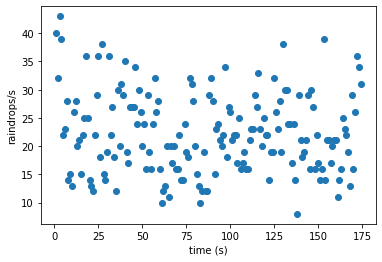

In [10]:
import numpy as np

from collections import defaultdict

rain_init = np.load('/pasteur/u/egoodma/projects/rain_init.npy',allow_pickle='TRUE').item()

time_dict = defaultdict(list)

for droplet_name, droplet_init in rain_init.items():
    time_dict[(droplet_init // 30)].append(droplet_name)
    
print(time_dict)

drops = []
time = []
for t in range(1, 1+max(time_dict.keys())):
    print(t, len(time_dict[t]))
    time.append(t)
    drops.append(len(time_dict[t]))
    
print(time, len(time), drops, len(drops))

import matplotlib.pyplot as plt
import pylab

plt.scatter(time,drops)
plt.xlabel('time (s)')
plt.ylabel('raindrops/s')